# Lab 5 - Ensembles 
Here is what we will do:
1. Create a data set with two input features and a 3 category target
2. Train a decision tree on the data set for a baseline
3. Train 3 ensemble models
    - Serial Ada Boosted DT
    - Decision Forest
    - Ensemble of DT, SVM, and NN
3. Get model performance on train and test sets
4. Create appropriate graphs
5. Do a 10 fold cross validation with 

### Prepare the data

### Settings for the generated dataset
This data set will be spirals with noise. 
- **arms** - This is the number of categories we will have   
- **turns** - How many times we go around the spiral   
- **width** - How wide is the spiral (percentage of the radius)   
- **noise** - How much noise we will add to the data.   
- **size** - The number of points to generate   

In [11]:
arms = 3
turns = 1.5
width = 0.3
noise = .25
size = 4000

### The spirals will be based on the equation r=theta

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 2.0943951023931953
Arm 2
Using offset 4.1887902047863905


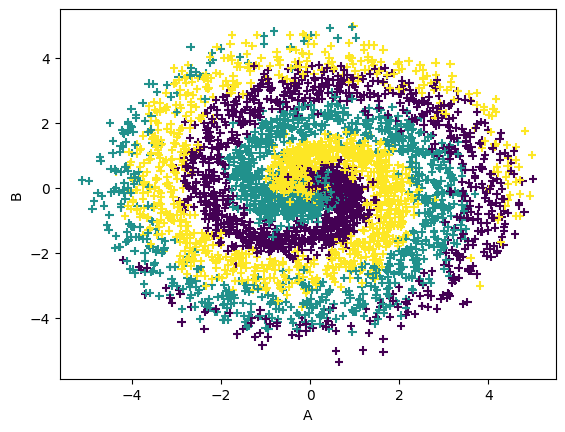

In [12]:

import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    




### Stratified Test/Train Data Split

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    test_set = spiral.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [14]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

**Base model →** train a single decision tree on your spiral dataset to see **baseline performance**.

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for decision tree on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[207  23  36]
 [ 41 187  39]
 [ 20  28 219]]
Accuracy is   0.76625
Precision is  0.7676608665854401
Recall is     0.76625
F1 is         0.7655290325132976


**Ensemble models →** build on that baseline:  

- **Boosting (AdaBoost) →** sequence of trees correcting each other’s mistakes
- **Random Forest →** many trees in parallel on random subsets of the data
- **Heterogeneous ensemble →** combine different model types (e.g., tree + SVM + neural net)
- **Cross-validated models →** test model stability and performance across multiple folds of the dataset

### Train and evaluate SVC model 

**Base model →** train a SVC model on your spiral dataset to see **baseline performance**.

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for svc on training data
  Default settings
Confusion Matrix
[[828 119 120]
 [164 768 134]
 [178 122 766]]
Accuracy is   0.7383557361675523
Precision is  0.7399307035244941
Recall is     0.7383557361675523
F1 is         0.7383133018337246

Results for svc on test data
  Default settings
Confusion Matrix
[[202  30  34]
 [ 47 179  41]
 [ 38  34 195]]
Accuracy is   0.72
Precision is  0.7209148223426679
Recall is     0.72
F1 is         0.7195790723261938


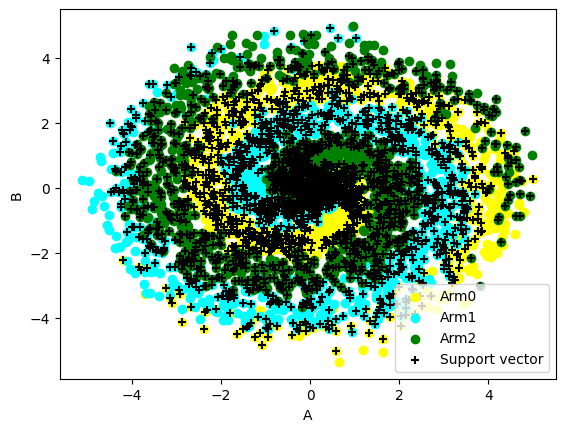

In [17]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

### Train and evaluate Neural Net model 

**Base model →** train a neural net on your spiral dataset to see **baseline performance**.

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
nn_model.fit(X,y)

y_pred = nn_model.predict(X)


print('Results for NN on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for NN on train data
  Default settings
Confusion Matrix
[[902  71  94]
 [ 85 881 100]
 [ 83  76 907]]
Accuracy is   0.8408877774304471
Precision is  0.8412642377919909
Recall is     0.8408877774304471
F1 is         0.840910296259135

Results for NN on test data
  Default settings
Confusion Matrix
[[222  21  23]
 [ 25 207  35]
 [ 15  21 231]]
Accuracy is   0.825
Precision is  0.8259604916403511
Recall is     0.825
F1 is         0.8247030758057403


/Users/joannafarris/Projects/applied-ml-farris/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Results
Basic results for our classification model to predict arm on the spiral data set

| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91

### Train and evaluate ADA boosted model

In [21]:
### Train and evaluate ADA boosted model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

X = train_set[['A','B']]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = AdaBoostClassifier(n_estimators=150, random_state=42)
ada_model.fit(X, y)

# -------- Training performance --------
y_pred = ada_model.predict(X)
print('Results for ADA on training data')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y, y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

# -------- Test performance --------
y_test_pred = ada_model.predict(X_test)
print('Results for ADA on test data')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test, y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))


Results for ADA on training data
Confusion Matrix
[[680 217 170]
 [147 704 215]
 [168 137 761]]
Accuracy is   0.6705220381369178
Precision is  0.670961354272885
Recall is     0.6705220381369178
F1 is         0.670169720131085

Results for ADA on test data
Confusion Matrix
[[159  63  44]
 [ 49 162  56]
 [ 31  34 202]]
Accuracy is   0.65375
Precision is  0.6531945100920065
Recall is     0.65375
F1 is         0.6519244510861104


| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|ADA|A,B, n_estimators=150|67.05|67.02|65.38|65.19|

## Train and evaluate Random Forest model

In [22]:
### Train and evaluate ADA boosted model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

X = train_set[['A','B']]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X,y)

# -------- Training performance --------
y_pred = rf_model.predict(X)
print('Results for Random Forest on training data')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y, y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

# -------- Test performance --------
y_test_pred = rf_model.predict(X_test)
print('Results for Random Forest on test data')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test, y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))


Results for Random Forest on training data
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for Random Forest on test data
Confusion Matrix
[[218  17  31]
 [ 30 203  34]
 [ 20  24 223]]
Accuracy is   0.805
Precision is  0.8065599544541636
Recall is     0.805
F1 is         0.8048533363284787


| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Random Forest|A,B, n_estimators=150|100.0|100.0|80.50|80.49|

## Train and evaluate Voting model 

We build it out of three different kinds of classifiers: DT, SVC and NN


In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

X = train_set[['A','B']]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

# Build the classifiers
vc1_dt = DecisionTreeClassifier()
vc2_svm = SVC()
vc3_nn = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
solver='lbfgs')

# Bundle into a list with names
vcList = [('DT',vc1_dt),
('SVM',vc2_svm),
('NN',vc3_nn)]

vote_model = VotingClassifier(vcList)
vote_model.fit(X,y)

# -------- Training performance --------
y_pred = vote_model.predict(X)
print('Results for Voting Ensemble on training data')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y, y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

# -------- Test performance --------
y_test_pred = vote_model.predict(X_test)
print('Results for Voting Ensemble on test data')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test, y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))


/Users/joannafarris/Projects/applied-ml-farris/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Voting Ensemble on training data
Confusion Matrix
[[978  54  35]
 [ 66 934  66]
 [ 94  27 945]]
Accuracy is   0.8930915911222257
Precision is  0.8943361388623471
Recall is     0.8930915911222257
F1 is         0.893200270061063

Results for Voting Ensemble on test data
Confusion Matrix
[[224  20  22]
 [ 32 199  36]
 [ 21  21 225]]
Accuracy is   0.81
Precision is  0.8109641813553214
Recall is     0.81
F1 is         0.8093930317097551


| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Vote Model|A,B|89.31|89.32|81.00|80.94|

## Cross Validate a Decision Tree model

#### 1. Set up for cross-validation
- Import the tools you need: StratifiedKFold for splitting, DecisionTreeClassifier for the model, and metrics.
- Create empty lists to store metrics from each fold.


In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

accuracy_list = []
f1_list = []

#### 2. Create the splitter

- 10 folds (n_splits=10)
- Shuffle before splitting (shuffle=True)
- Fix randomness with random_state=123 for reproducibility


In [33]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

#### 3. Loop through each fold

For each fold:

- Split the data into a training set and validation set.
- Extract features (A, B) and target (Class).
- Train a new decision tree on the training set.
- Evaluate on the validation fold: compute accuracy, F1, and print confusion matrix.
- Append accuracy and F1 to the lists.

In [34]:
for train_indices, validate_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    validate_set = spiral.iloc[validate_indices]
    
    X_train = train_set[['A', 'B']]
    y_train = train_set['Class']
    X_validate = validate_set[['A', 'B']]
    y_validate = validate_set['Class']
    
    # Train model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    # Predict on validation fold
    y_validate_pred = model.predict(X_validate)
    
    # Compute metrics
    acc = accuracy_score(y_validate, y_validate_pred)
    f1 = f1_score(y_validate, y_validate_pred, average='weighted')
    
    # Print fold results
    print("Confusion Matrix")
    print(confusion_matrix(y_validate, y_validate_pred))
    print("Accuracy:", acc)
    
    # Store metrics
    accuracy_list.append(acc)
    f1_list.append(f1)

Confusion Matrix
[[ 96  15  23]
 [ 11 106  16]
 [  9  16 108]]
Accuracy: 0.775
Confusion Matrix
[[110  19   5]
 [ 16  99  18]
 [ 22  14  97]]
Accuracy: 0.765
Confusion Matrix
[[105  17  12]
 [ 19  97  17]
 [ 17  17  99]]
Accuracy: 0.7525
Confusion Matrix
[[ 97  16  20]
 [ 10 104  20]
 [ 15  15 103]]
Accuracy: 0.76
Confusion Matrix
[[ 98  12  23]
 [ 14 108  12]
 [ 13  22  98]]
Accuracy: 0.76
Confusion Matrix
[[109  14  10]
 [ 19 104  11]
 [ 11  22 100]]
Accuracy: 0.7825
Confusion Matrix
[[105  12  16]
 [ 17  96  20]
 [ 11  20 103]]
Accuracy: 0.76
Confusion Matrix
[[105  15  13]
 [ 13 107  13]
 [ 19  21  94]]
Accuracy: 0.765
Confusion Matrix
[[ 94  15  24]
 [ 20  91  22]
 [ 14  17 103]]
Accuracy: 0.72
Confusion Matrix
[[ 99  16  18]
 [ 20  90  23]
 [ 13  20 100]]
Accuracy: 0.7243107769423559


#### 4. Compute average and standard deviation
- After the loop, summarize the performance across all folds:

In [35]:
accuracy_array = np.array(accuracy_list)
f1_array = np.array(f1_list)

print("Accuracy values:", accuracy_array)
print("Average accuracy:", np.average(accuracy_array))
print("StDev of accuracy:", np.std(accuracy_array))

print("Average F1:", np.average(f1_array))
print("StDev of F1:", np.std(f1_array))

Accuracy values: [0.775      0.765      0.7525     0.76       0.76       0.7825
 0.76       0.765      0.72       0.72431078]
Average accuracy: 0.7564310776942356
StDev of accuracy: 0.018931055380544556
Average F1: 0.756255410235332
StDev of F1: 0.01898940158162339


| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91|
|ADA|A,B, n_estimators=150|67.05|67.02|65.38|65.19|
|Random Forest|A,B, n_estimators=150|100.0|100.0|80.50|80.49|
|Vote Model|A,B|89.31|89.32|81.00|80.94|
